<center><h1>WISD&EID2/Deep Learning</center></h1> 

<center><h1>TP 5 </center><h1>

<center><h1>Convolutions Neural Networks</center><h1>


---
By: **Lamgarraj Mohamed**   &   **Yazid Tagnaouti Moumnani**


---

PRACTICAL LECTURE 5



Convolutions Neural Networks

1. Import the librariries and set the parameters

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [ ]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

2. Load the Dataset (MNIST) using PyTorch DataLoader utilities and visualize some images :


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



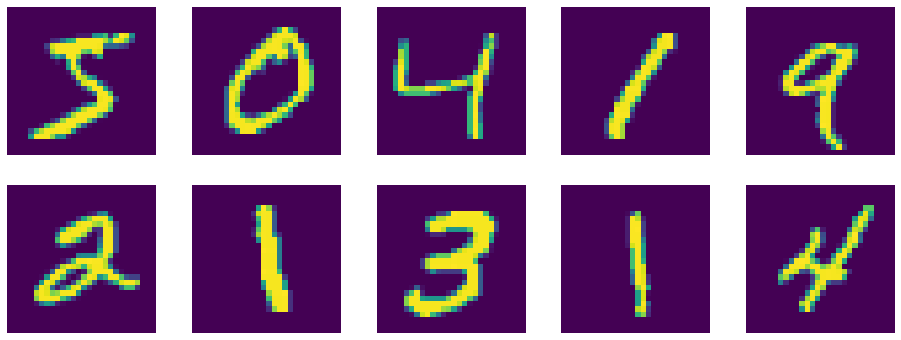

In [ ]:

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

3. Create the model classes




In [ ]:
input_size  = 28*28   # size of images
output_size = 10      # number of classes
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

4. Run on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [ ]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

5. Train a small fully-connected network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


In [ ]:
n_hidden = 8 # 8 hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.378340
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.047126
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.586199
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.847511
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.589556
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.364731
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.471546
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.403943
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.305007
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.324629

Test set: Average loss: 0.3834, Accuracy: 8908/10000 (89%)



6. Train a ConvNet with the same number of parameters

In [ ]:

n_features = 6 # 6 feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.323067
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.178814
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.496994
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.277784
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.532341
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.167138
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.184305
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.304587
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.118713
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.073599

Test set: Average loss: 0.2348, Accuracy: 9231/10000 (92%)



7. Changes the parameters oof the model.



Permute pixels

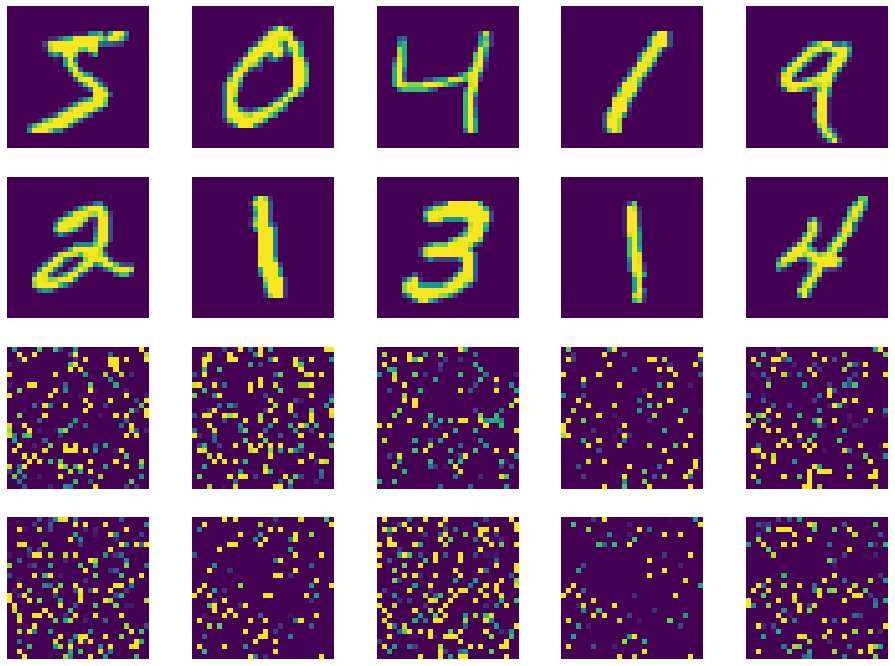

In [ ]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

**Fully-Connected with Permuted Pixels**

In [ ]:
n_hidden = 16
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.001, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 13002
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.375173
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.278405
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.237041
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.163812
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.110027
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.100720
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.022943
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.918237
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.945596
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.789846

Test set: Average loss: 1.7065, Accuracy: 3753/10000 (38%)



**ConvNet with permuted pixels**

In [ ]:
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 4):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.324884
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.297187
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.302403
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.292019
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.279848
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.252449
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.237640
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.226127
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.197772
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.152089

Test set: Average loss: 2.0871, Accuracy: 3926/10000 (39%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.124026
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.965882
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.674858
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.446777
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.181203
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.119126
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.856690
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.713728
Train Epoch: 1 [51200/60

8. Analyze the results and the impact of these paremeters.

**Le ConvNet est plus performant avec le même nombre de paramètres, grâce à son utilisation des connaissances préalables sur les images**

Les performances de ConvNet chutent lorsque nous permutons les pixels, mais les performances du réseau entièrement connecté restent les mêmes 
* ConvNet suppose que les pixels se trouvent sur une grille et sont stationnaires/locaux 
* Il perd des performances lorsque cette hypothèse est fausse
* Le réseau entièrement connecté ne fait pas cette hypothèse
* Il réussit moins bien quand c'est vrai, car il ne profite pas de ces connaissances préalables.

Mais ça ne souffre pas quand l'hypothèse est fausse